# Machine Learning Exercise

Now it's time to practice what you have seen in the previous notebooks. Your task for today is to download the data from the database and train a model in order to predict if a patient has a heart disease or not. 

![](https://www.nicepng.com/png/detail/397-3975460_disease-high-quality-png-heart-disease-cartoon-png.png)

## Task:

1. Import the data from the database. The schema is called `heart`. You can use DBeaver to get an overview over the different tables and think about a good way to join them. 
2. Split the data into train and test
3. Conduct a brief EDA on the train data to become familiar with the data. 
4. Preprocess the data as far as you need it (feature Engineering)and ...
5. ...train a logistic regression model.

## What you should use/keep in mind:
 
* **Scale your data:** Which scaler works best in your case?
* **Tune your model:** Tune the hyperparameter of your model. You can start with a larger parameter grid and a `RandomizedSearchCV` and continue with a narrower parameter grid for your `GridSearchCV`.
* **Choose the right evaluation metric!**


## Data Overview

| column | additional information |
|--------|------------------------|
| age | age of patient |
| sex | gender of patient |
| chest_pain_type  | 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic | 
| resting_blood_pressure |  | 
| fasting_blood_sugar | > 120 mg/dl, 1 = true, 0 = false | 
| thal | 0 = normal, 1 = fixed defect, 2 = reversable defect
| serum_cholestoral | in mg/dl | 
| resting_electrocardiographic_results | 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria | 
| maximum_heartrate_achieved | | 
| exercise_induced_angina | 1 = yes, 0 = no | 
| oldpeak | ST depression induced by exercise relative to rest | 
| slope_of_the_peak_exercise_st_segment | 1= upsloping, 2 = flat, 3 = downsloping | 
| number_of_major_vessels_colored_by_flourosopy | |
| real_data | tag to distinguish between real and made up data | 
| heart_attack | 0 = little risk of heart attack, 1 = high risk of heart attack | 

## Import

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feel free to add all the libraries you need

## Getting the Data

The data for this exercise is stored in our postgres database in the schema `heart`. The different features are split thematically into five different tables. Your first task will be to have a look at the tables (e.g. in DBeaver) and figure out a way to join the information you need. As soon as you're happy with your query, you can use the following code cells to import the data into this notebook. 

In previous notebooks you've seen two different approaches to import data from a database into a notebook. The following code will use `sqlalchemy`in combination with pandas `pd.read_sql()` function. For the code to work, you need to copy the `.env` file from the previous repositories into this repository and change the query_string to your own query.

In [32]:
# Read database string from .env file (no need to change anything)
load_dotenv(override=True)

DB_STRING = os.getenv('DB_STRING')


db = create_engine(DB_STRING)

In [33]:
query_string = """
SELECT
    p.id AS patient_id,
    p.age,
    p.sex,

    -- blood metrics
    bm.serum_cholestoral,
    bm.fasting_blood_sugar,
    bm.thal,

    -- chest pain
    cp.chest_pain_type,

    -- pressure, vessels & angina
    pv.resting_blood_pressure,
    pv.resting_electrocardiographic_results,
    pv.maximum_heartrate_achieved,
    pv.exercise_induced_angina,
    pv.oldpeak,
    pv.slope_of_the_peak_exercise_st_segment,
    pv.number_of_major_vessels_colored_by_flourosopy,
    pv.real_data,

    -- TARGET
    hah.heart_attack

FROM heart.patient p

LEFT JOIN heart.blood_metrics bm
    ON p.id = bm.patient_id

LEFT JOIN heart.chest_pain cp
    ON p.id = cp.patient_id

LEFT JOIN heart.pressure_vessels_angina pv
    ON p.id = pv.patient_id

LEFT JOIN heart.heart_attack_history hah
    ON p.id = hah.patient_id
"""


In [34]:
df_sqlalchemy = pd.read_sql(query_string, db)
df_sqlalchemy.head()

,patient_id,age,sex,serum_cholestoral,fasting_blood_sugar,thal,chest_pain_type,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,real_data,heart_attack
0,0,63.0,1.0,233.0,1.0,1.0,3.0,145.0,0.0,150.0,0.0,2.3,0.0,0.0,real data,1
1,1,NaN,1.0,250.0,0.0,2.0,2.0,130.0,1.0,187.0,0.0,3.5,0.0,0.0,real data,1
2,2,41.0,0.0,204.0,0.0,2.0,1.0,130.0,0.0,172.0,0.0,1.4,2.0,0.0,real data,1
3,3,56.0,1.0,236.0,0.0,2.0,1.0,120.0,1.0,178.0,0.0,0.8,2.0,0.0,real data,1
4,4,57.0,0.0,354.0,0.0,2.0,0.0,120.0,1.0,163.0,1.0,0.6,2.0,0.0,None,1


In [38]:
# Save dataframe as .csv file
df_sqlalchemy.to_csv("data/heart_data.csv", index=False)

## 2. Technical Setup and Utilities

### 2.1 Imports

In [42]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📐 Statistics (optional / analysis support)
# ============================================================
import scipy.stats as stats

# ============================================================
# 🤖 Machine Learning — Data Splitting & Validation
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_validate
)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ============================================================
# ⚖️ Classification Models
# ============================================================
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

# ============================================================
# ⚡ Imbalanced Learning
# ============================================================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ============================================================
# 📏 Evaluation Metrics
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ============================================================
# 🔍 Model Inspection & Interpretation
# ============================================================
from sklearn.inspection import (
    permutation_importance,
    PartialDependenceDisplay
)

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 🎨 Project Styling
# ============================================================
MAIN_COLOR = "#B388EB"

### 2.2 Model Evaluation Utilities
This section defines reusable evaluation functions used across
all classification models in this notebook.

The goal is to ensure consistent metric computation, fair model comparison,
and clear visualization of classification performance under class imbalance.

In [43]:

RANDOM_STATE = 0

def metric_report(y_true, y_pred, y_proba=None, label="model"):
    # Basic metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC-AUC (if probabilities are provided)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    # PR-AUC
    if y_proba is not None:
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = auc(rec_curve, prec_curve)
    else:
        pr_auc = None

    out = {
        "model": label,
        "accuracy": acc,
        "precision": prec,
        "specificity": spec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }
    return out

def plot_roc_pr(y_true, y_score, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    rocA = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    prA = auc(rec, prec)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(rec, prec, label=f"AP={prA:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} Precision-Recall"); plt.legend()
    plt.show()

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title); plt.show()

### 2.3 Model Result Logging
This section defines a lightweight logging mechanism used to
collect and compare final performance metrics across models.

Each model appends a single summary row after evaluation,
allowing compact comparison in tabular form.

In [44]:
# ====================================
# Classification Log Collector
# ====================================

# No need to import pandas again!

# Safe init

class_log = []

def log_class_result(model_name, acc, prec, spec, rec, f1, roc_auc, pr_auc, feature_count=None):
    class_log.append({
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Specificity": round(spec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3),
        "ROC_AUC": round(roc_auc, 3) if roc_auc is not None else None,
        "PR_AUC": round(pr_auc,3) if pr_auc is not None else None,
        "Feature_Count": int(feature_count) if feature_count is not None else None
    })

### 2.4 Threshold Optimization Utilities
This section defines reusable tools for selecting and evaluating
decision thresholds based on predicted probabilities.

Threshold optimization is treated as a post-modeling decision step
and is aligned with business objectives such as maximizing recall,
precision, or balanced performance.

In [45]:
# ============================================
# Threshold Optimization Tools (Steps A–C)
# ============================================

# =====================
# Step A — Threshold sweep
# =====================
def threshold_sweep(y_true, y_score, thresholds=None):
    """
    Sweep thresholds and compute metrics using metric_report.
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        m = metric_report(y_true, y_pred, y_score, label=f"t={t:.3f}")

        rows.append({
            "threshold": t,
            "accuracy":   m["accuracy"],
            "precision":  m["precision"],
            "specificity": m["specificity"],
            "recall":     m["recall"],
            "f1":         m["f1"],
            "roc_auc":    m["roc_auc"],
            "pr_auc":     m["pr_auc"],
        })
    return pd.DataFrame(rows)


# =====================
# Step B — Choose threshold by objective
# =====================
def choose_threshold_by_objective(sweep_df, objective="f1_max", target=0.8):

    if objective == "f1_max":
        i = sweep_df["f1"].idxmax()
        return float(sweep_df.loc[i, "threshold"]), "F1-max"

    if objective == "precision_at":
        df = sweep_df[sweep_df["precision"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"precision_at({target}) — best available"
        i = df["recall"].idxmax()
        return float(df.loc[i, "threshold"]), f"precision≥{target}, max recall"

    if objective == "recall_at":
        df = sweep_df[sweep_df["recall"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"recall_at({target}) — best available"
        i = df["precision"].idxmax()
        return float(df.loc[i, "threshold"]), f"recall≥{target}, max precision"

    raise ValueError("Unknown objective")


# =====================
# Step C — Evaluate model at chosen threshold
# =====================
#def show_at_threshold(y_true, y_score, t, label=""):
#   y_pred = (y_score >= t).astype(int)
#    show_confusion(y_true, y_pred, f"{label} (t={t:.2f})")
#    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")

# ============================================
def show_at_threshold(y_true, y_score, t, label=""):
    y_pred = (y_score >= t).astype(int)

    # Confusion matrix (normalized)
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))

    # Base heatmap (no cmap meaning yet)
    im = ax.imshow(cm, vmin=0, vmax=1)

    # Define pastel colors
    green_pastel = "#C2E7C4"   # correct predictions
    red_pastel   = "#F0C6C3"   # incorrect predictions

    # Apply semantic coloring cell by cell
    for i in range(2):
        for j in range(2):
            if i == j:
                ax.add_patch(
                    plt.Rectangle(
                        (j - 0.5, i - 0.5),
                        1, 1,
                        facecolor=green_pastel,
                        edgecolor="white"
                    )
                )
            else:
                ax.add_patch(
                    plt.Rectangle(
                        (j - 0.5, i - 0.5),
                        1, 1,
                        facecolor=red_pastel,
                        edgecolor="white"
                    )
                )

            ax.text(
                j, i,
                f"{cm[i, j]:.0f}",
                ha="center", va="center",
                fontsize=11,
                color="black"
            )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"], fontsize=9)
    ax.set_yticklabels(["True 0", "True 1"], fontsize=9)

    ax.set_title(f"{label}\n(t = {t:.2f})", fontsize=10)

    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    plt.tight_layout()
    plt.show()

    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")


 ### 2.5 IQR-Based Outlier Handling Utilities

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k

    def fit(self, X, y=None):
        # Ensure DataFrame for column-wise operations
        X = pd.DataFrame(X)

        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1

        self.lower_bounds_ = q1 - self.k * iqr
        self.upper_bounds_ = q3 + self.k * iqr

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in X.columns:
            X[col] = X[col].clip(
                lower=self.lower_bounds_[col],
                upper=self.upper_bounds_[col]
            )

        return X

## 3. Data Preparation

### 3.1 Load Raw Data
- Load the cleaned modeling dataset
- Define the binary target variable: `heart_attack`

In [61]:
# Load raw marketing campaign dataset
df = pd.read_csv('Data/heart_data.csv')
df.head(10)

,patient_id,age,sex,serum_cholestoral,fasting_blood_sugar,thal,chest_pain_type,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,real_data,heart_attack
0,0,63.0,1.0,233.0,1.0,1.0,3.0,145.0,0.0,150.0,0.0,2.3,0.0,0.0,real data,1
1,1,NaN,1.0,250.0,0.0,2.0,2.0,130.0,1.0,187.0,0.0,3.5,0.0,0.0,real data,1
2,2,41.0,0.0,204.0,0.0,2.0,1.0,130.0,0.0,172.0,0.0,1.4,2.0,0.0,real data,1
3,3,56.0,1.0,236.0,0.0,2.0,1.0,120.0,1.0,178.0,0.0,0.8,2.0,0.0,real data,1
4,4,57.0,0.0,354.0,0.0,2.0,0.0,120.0,1.0,163.0,1.0,0.6,2.0,0.0,NaN,1
5,5,57.0,1.0,192.0,0.0,1.0,0.0,140.0,1.0,148.0,0.0,0.4,1.0,0.0,real data,1
6,6,NaN,0.0,294.0,0.0,2.0,1.0,140.0,0.0,153.0,0.0,1.3,1.0,0.0,real data,1
7,7,44.0,1.0,263.0,0.0,3.0,1.0,120.0,1.0,173.0,0.0,0.0,2.0,0.0,real data,1
8,8,52.0,1.0,199.0,1.0,3.0,2.0,172.0,1.0,162.0,0.0,0.5,2.0,0.0,real data,1
9,9,57.0,1.0,168.0,0.0,2.0,2.0,150.0,1.0,174.0,0.0,1.6,2.0,0.0,NaN,1


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   patient_id                                     403 non-null    int64  
 1   age                                            393 non-null    float64
 2   sex                                            384 non-null    float64
 3   serum_cholestoral                              303 non-null    float64
 4   fasting_blood_sugar                            303 non-null    float64
 5   thal                                           303 non-null    float64
 6   chest_pain_type                                303 non-null    float64
 7   resting_blood_pressure                         353 non-null    float64
 8   resting_electrocardiographic_results           353 non-null    float64
 9   maximum_heartrate_achieved                     342 non

In [82]:
df["real_data"].unique()

array(['real data', nan,
       'Evgeny likes white wine for lunch and red wine for dinner'],
      dtype=object)

### 3.2 Data Filtering: Real Records Only

Before performing the train–test split and exploratory analysis, the dataset
is filtered to retain only real clinical records. The column `real_data` is
not a predictive feature, but rather a data validity indicator used to identify
synthetic, incomplete, or non-clinical entries.

This filtering step ensures that all subsequent analyses (missing values,
outlier inspection, and distributional assessments) reflect the true structure
and quality of the real clinical data.


In [83]:
# ----------------------------------
# 3.2 Data Filtering: Real Records Only
# ----------------------------------

print(df["real_data"].unique())

# Keep only real clinical records
df = df[df["real_data"] == "real data"].copy()

# Drop the data validity flag from features
df = df.drop(columns=["real_data"])

# Sanity check after filtering
df.shape


['real data' nan
 'Evgeny likes white wine for lunch and red wine for dinner']


(243, 15)

### 3.3 Train / Test Split

In [85]:
# ----------------------------------
# 3.3 Train / Test Split
# ----------------------------------

# Define target (binary classification)
y = df["heart_attack"]

# Define feature matrix
X = df.drop(columns=["heart_attack","patient_id"])

# Perform stratified train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# Sanity check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194, 13), (49, 13), (194,), (49,))

### 3.4 Exploratory Analysis for Preprocessing Decisions

In this section, we explore the dataset from a modeling perspective.
The goal is not to derive business insights, but to understand feature
types, distributions, missingness, and potential data issues in order
to make informed preprocessing and transformation decisions.

#### 3.4.1 Feature Overview and Data Types 

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 186 to 172
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   age                                            187 non-null    float64
 1   sex                                            181 non-null    float64
 2   serum_cholestoral                              194 non-null    float64
 3   fasting_blood_sugar                            194 non-null    float64
 4   thal                                           194 non-null    float64
 5   chest_pain_type                                194 non-null    float64
 6   resting_blood_pressure                         194 non-null    float64
 7   resting_electrocardiographic_results           194 non-null    float64
 8   maximum_heartrate_achieved                     185 non-null    float64
 9   exercise_induced_angina                        194 non-nu

In [87]:
X_train.head(10)

,age,sex,serum_cholestoral,fasting_blood_sugar,thal,chest_pain_type,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy
186,60.0,1.0,253.0,0.0,3.0,0.0,130.0,1.0,144.0,1.0,1.4,2.0,1.0
201,60.0,1.0,258.0,0.0,3.0,0.0,125.0,0.0,141.0,1.0,2.8,1.0,1.0
35,46.0,0.0,177.0,0.0,2.0,2.0,142.0,0.0,160.0,1.0,1.4,0.0,0.0
105,68.0,0.0,211.0,0.0,2.0,2.0,120.0,0.0,115.0,0.0,1.5,1.0,0.0
265,66.0,1.0,212.0,0.0,2.0,0.0,112.0,0.0,132.0,1.0,0.1,2.0,1.0
20,59.0,1.0,234.0,0.0,3.0,0.0,135.0,1.0,161.0,0.0,0.5,1.0,0.0
126,47.0,1.0,204.0,0.0,2.0,0.0,112.0,1.0,143.0,0.0,0.1,2.0,0.0
276,58.0,1.0,218.0,0.0,3.0,0.0,146.0,1.0,105.0,0.0,2.0,1.0,1.0
108,50.0,0.0,244.0,0.0,2.0,1.0,120.0,1.0,NaN,0.0,1.1,2.0,0.0
36,54.0,0.0,304.0,1.0,2.0,2.0,135.0,1.0,170.0,0.0,0.0,2.0,0.0


In [88]:
print("\n=== DESCRIBE (numeric) ===")
display(X_train.select_dtypes(include="number").describe().T)


=== DESCRIBE (numeric) ===


,count,mean,std,min,25%,50%,75%,max
age,187.0,54.122995,9.080930,34.0,46.50,54.0,61.00,77.0
sex,181.0,0.729282,0.445563,0.0,0.00,1.0,1.00,1.0
serum_cholestoral,194.0,245.489691,49.667729,126.0,215.25,240.0,273.75,564.0
fasting_blood_sugar,194.0,0.144330,0.352333,0.0,0.00,0.0,0.00,1.0
thal,194.0,2.304124,0.640016,0.0,2.00,2.0,3.00,3.0
chest_pain_type,194.0,0.917526,0.983492,0.0,0.00,1.0,2.00,3.0
resting_blood_pressure,194.0,131.067010,17.421642,94.0,120.00,130.0,140.00,180.0
resting_electrocardiographic_results,194.0,0.587629,0.503924,0.0,0.00,1.0,1.00,2.0
maximum_heartrate_achieved,185.0,148.675676,23.988736,71.0,134.00,151.0,168.00,194.0
exercise_induced_angina,194.0,0.314433,0.465491,0.0,0.00,0.0,1.00,1.0


### Feature Grouping and Preprocessing Considerations

Based on data types, semantic meaning, and modeling requirements, the features
were grouped into four categories to guide preprocessing decisions.

#### 1. Continuous Numerical Features
These variables represent true continuous measurements and are suitable
for numerical transformations.

- `age`
- `serum_cholestoral`
- `resting_blood_pressure`
- `maximum_heartrate_achieved`
- `oldpeak`

**Planned preprocessing:**
- Median imputation for missing values
- Feature scaling (e.g., StandardScaler)



#### 2. Binary Features
These variables encode binary medical conditions and are best represented
as integer-valued features.

- `sex`
- `fasting_blood_sugar`
- `exercise_induced_angina`

**Planned preprocessing:**
- Cast to integer type (0 / 1)
- No scaling applied



#### 3. Categorical (Non-Binary) Features
These variables represent categorical or ordinal clinical information
encoded as numeric values but without meaningful numeric distance.

- `chest_pain_type`
- `resting_electrocardiographic_results`
- `slope_of_the_peak_exercise_st_segment`
- `thal`

**Planned preprocessing:**
- Treat as categorical variables
- One-hot encoding



#### 4. Discrete Numeric Features
These features represent small-range integer counts with numerical meaning.

- `number_of_major_vessels_colored_by_flourosopy`

**Planned preprocessing:**
- Retain as numeric feature
- No scaling applied



#### 3.4.2 Missing Values and Data Quality 

In [89]:
missing_summary = (
    X_train.isna()
    .mean()
    .mul(100)
    .round(1)
    .rename("missing_percentage")
    .sort_values(ascending=False)
)

missing_summary


sex                                              6.7
maximum_heartrate_achieved                       4.6
age                                              3.6
serum_cholestoral                                0.0
fasting_blood_sugar                              0.0
thal                                             0.0
chest_pain_type                                  0.0
resting_blood_pressure                           0.0
resting_electrocardiographic_results             0.0
exercise_induced_angina                          0.0
oldpeak                                          0.0
slope_of_the_peak_exercise_st_segment            0.0
number_of_major_vessels_colored_by_flourosopy    0.0
Name: missing_percentage, dtype: float64

### Missing Values After Data Filtering

After restricting the dataset to real clinical records only, the overall
missingness is substantially reduced. Most clinical features no longer
contain missing values, indicating that missingness in the original dataset
was largely driven by non-real or incomplete records.

At this stage, only three features exhibit remaining missing values:

- `sex` (6.7%)
- `maximum_heartrate_achieved` (4.6%)
- `age` (3.6%)

The proportion of missing values in these variables is low and does not
indicate a data quality issue. All remaining missing values will be handled
during preprocessing using feature-appropriate imputation strategies.
No features are removed at this stage.


#### 3.4.3 Duplicate Records and Data Integrity Checks

In [93]:
# Check for fully duplicated rows
n_duplicates = X_train.duplicated().sum()
n_duplicates

np.int64(0)

After filtering the dataset to retain real clinical records only, no fully
duplicated observations remain in the training data. Therefore, no duplicate
handling is required at this stage.


#### 3.4.4 Distribution and Outlier Inspection (Training Data Only)

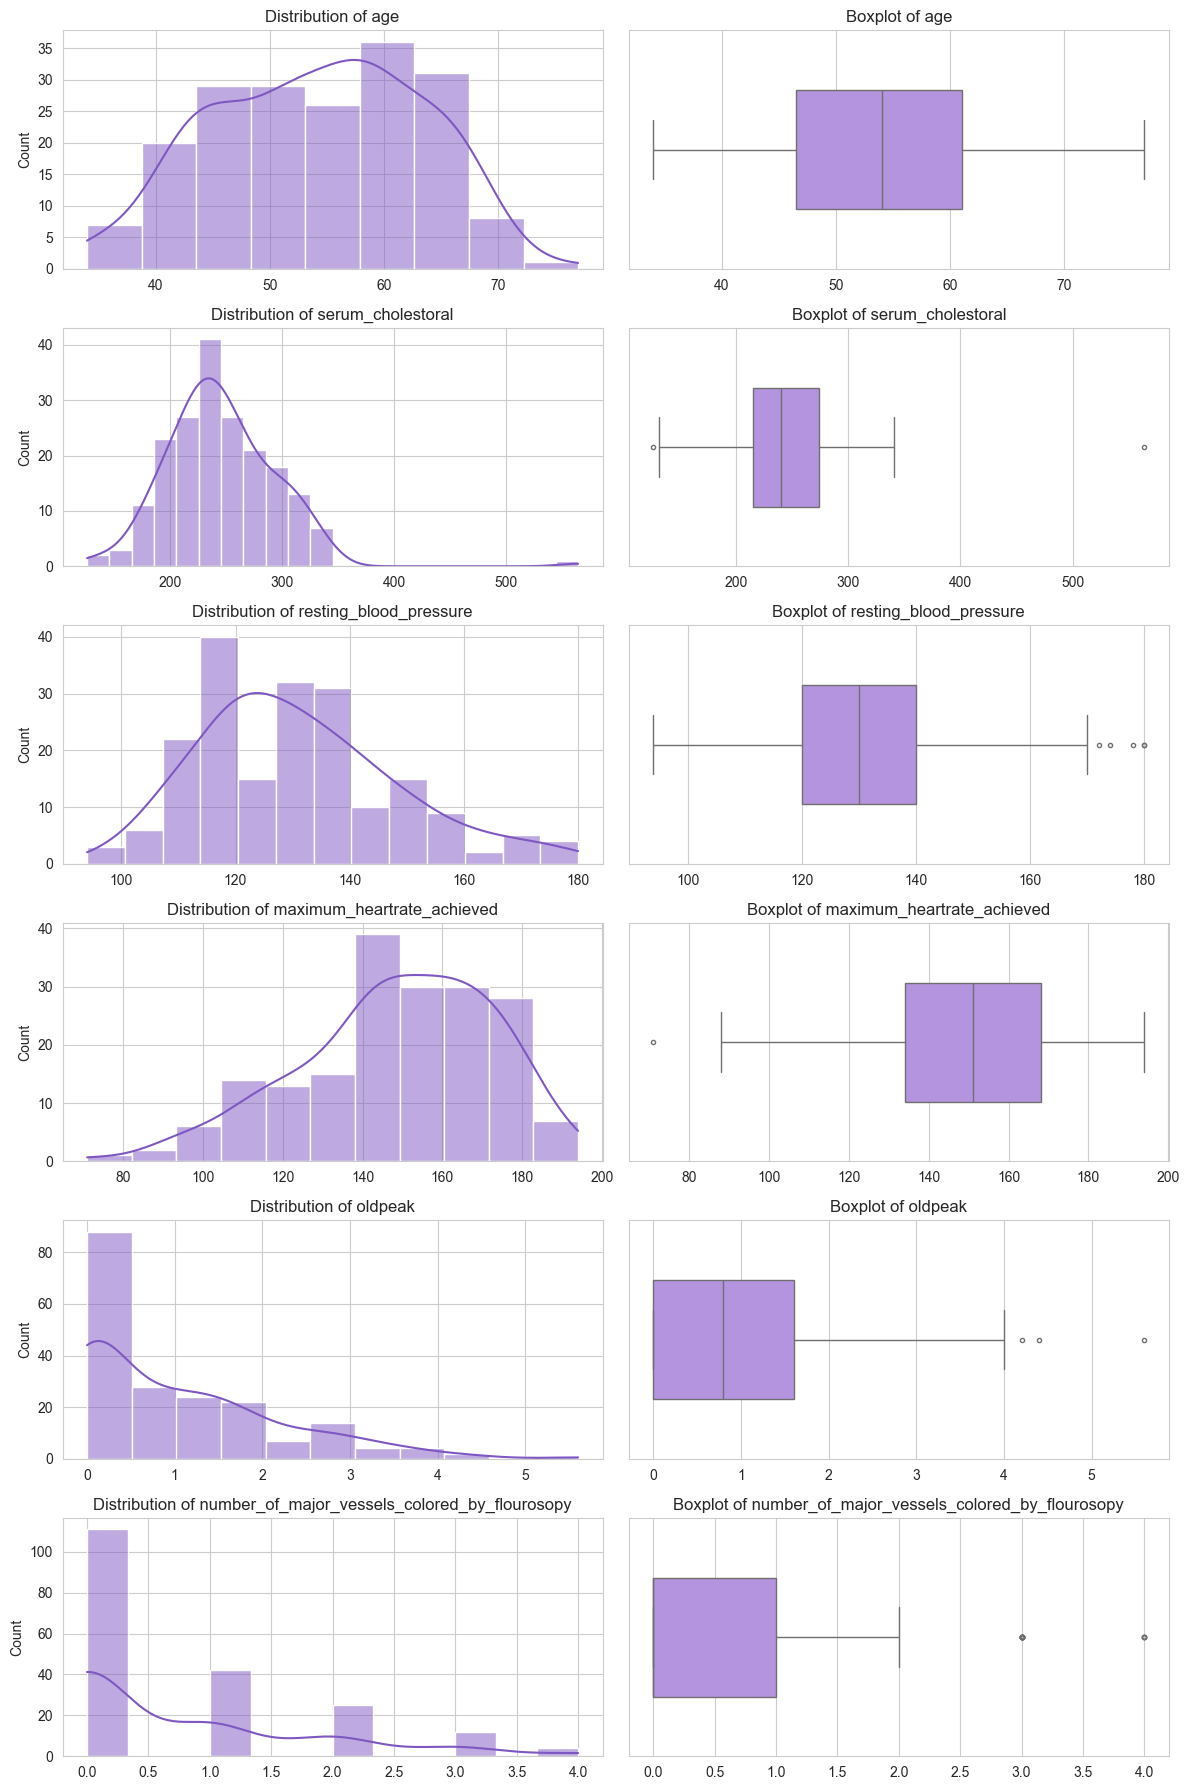

In [122]:
# ----------------------------------
# 3.4.4 Distribution and Outlier Inspection (Training Data Only)
# ----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [
    "age",
    "serum_cholestoral",
    "resting_blood_pressure",
    "maximum_heartrate_achieved",
    "oldpeak",
    "number_of_major_vessels_colored_by_flourosopy"
]

sns.set_style("whitegrid")

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 3 * len(num_cols)))

for i, col in enumerate(num_cols):
    # Histogram + KDE
    sns.histplot(
        X_train[col],
        kde=True,
        ax=axes[i, 0],
        color="#7E57C2"
    )
    axes[i, 0].set_title(f"Distribution of {col}")
    axes[i, 0].set_xlabel("")

    # Boxplot
    sns.boxplot(
        x=X_train[col],
        ax=axes[i, 1],
        color="#B388EB",
        width=0.5,
        fliersize=3
    )
    axes[i, 1].set_title(f"Boxplot of {col}")
    axes[i, 1].set_xlabel("")

plt.tight_layout()
plt.show()


The numerical features exhibit varying degrees of skewness and extreme values.
Most outliers are clinically plausible and are therefore retained. The primary
concern is distributional skew rather than data corruption, suggesting the use
of robust scaling or transformation during preprocessing.

#### 3.4.5 Categorical Feature Inspection and Encoding

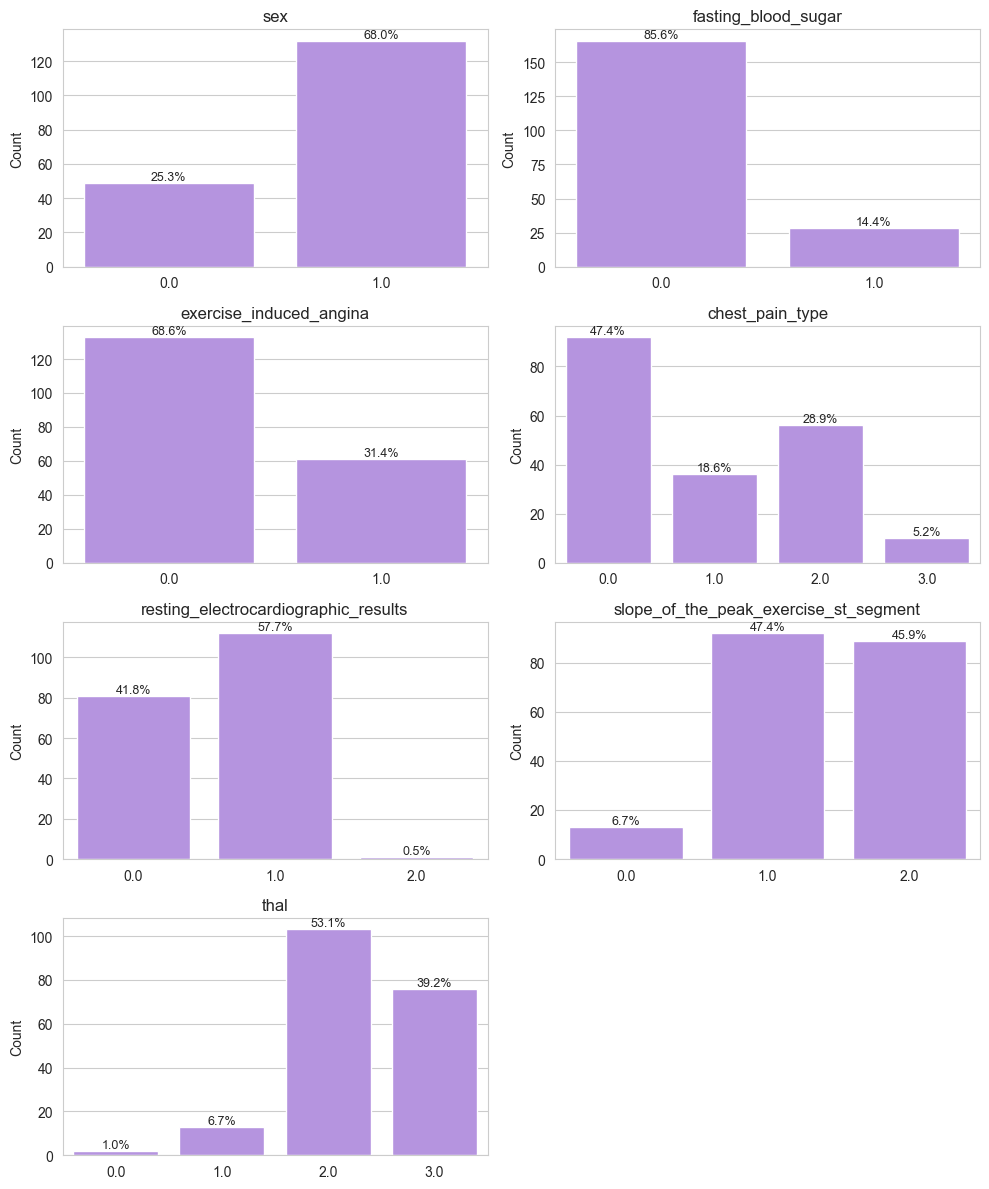

In [123]:
# ----------------------------------
# 3.4.5 Categorical Feature Inspection (Compact Visual)
# ----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
COLOR = "#B388EB"

# All categorical features
cat_cols = [
    "sex",
    "fasting_blood_sugar",
    "exercise_induced_angina",
    "chest_pain_type",
    "resting_electrocardiographic_results",
    "slope_of_the_peak_exercise_st_segment",
    "thal"
]

n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axes = axes.flatten()

total_n = len(X_train)

for i, col in enumerate(cat_cols):
    counts = X_train[col].value_counts().sort_index()
    percents = counts / total_n * 100

    sns.barplot(
        x=counts.index.astype(str),
        y=counts.values,
        color=COLOR,
        ax=axes[i]
    )

    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("")

    # add percentage labels on top of bars
    for j, (count, pct) in enumerate(zip(counts.values, percents.values)):
        axes[i].text(
            j,
            count,
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

# remove empty subplots if any
for k in range(i + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


Overall, categorical features exhibit low to moderate cardinality with no
severe rare-category issues. Although most categorical variables are stored
as floating-point values, they represent encoded category labels rather than
continuous measurements. Binary categorical features are retained as integer-
encoded variables, while non-binary categorical features are handled via
one-hot encoding. No category grouping or feature removal is required at
this stage.

#### 3.4.6 Target Distribution and Class Imbalance  

In [103]:
y_train.isna().sum(), y_test.isna().sum()

(np.int64(0), np.int64(0))

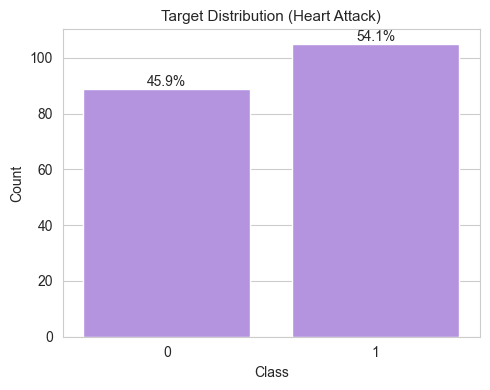

In [102]:
# ----------------------------------
# 3.4.6 Target Distribution and Class Imbalance (Visual)
# ----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
COLOR = "#B388EB"

# Counts and percentages
counts = y_train.value_counts().sort_index()
percentages = y_train.value_counts(normalize=True).sort_index() * 100

fig, ax = plt.subplots(figsize=(5, 4))

sns.barplot(
    x=counts.index.astype(str),
    y=counts.values,
    color=COLOR,
    ax=ax
)

ax.set_title("Target Distribution (Heart Attack)", fontsize=11)
ax.set_xlabel("Class")
ax.set_ylabel("Count")

# Add percentage labels on top of bars
for i, (count, pct) in enumerate(zip(counts.values, percentages.values)):
    ax.text(
        i,
        count,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


The target variable contains no missing values in either the training or test
set. In addition, the class distribution is approximately balanced
(45.9% vs. 54.1%), indicating that no significant class imbalance is present.
Therefore, no imbalance-specific resampling techniques are required.

#### 3.4.7 Feature–Feature and Feature–Target Correlation Analysis

#### 1) Correlation Matrix (including target)

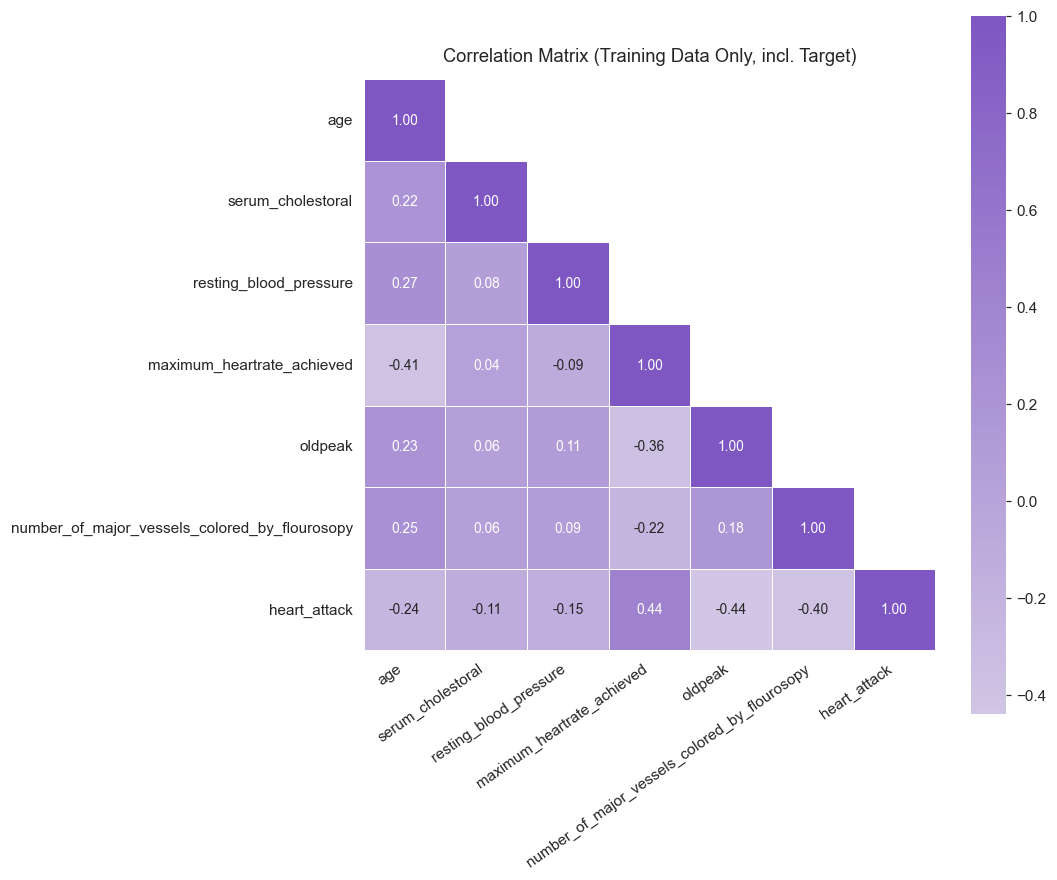

In [133]:
# ----------------------------------
# 3.4.7 Correlation Analysis (Readable Half Matrix)
# ----------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

corr_cols = [
    "age",
    "serum_cholestoral",
    "resting_blood_pressure",
    "maximum_heartrate_achieved",
    "oldpeak",
    "number_of_major_vessels_colored_by_flourosopy"
]

corr_df = pd.concat(
    [X_train[corr_cols], y_train.rename("heart_attack")],
    axis=1
)

corr = corr_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

cmap = sns.light_palette("#7E57C2", as_cmap=True)

# 🔥 Bigger figure + better DPI
fig, ax = plt.subplots(figsize=(10, 10), dpi=110)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9},     # smaller numbers but readable
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Rotate labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_title("Correlation Matrix (Training Data Only, incl. Target)", pad=12)

plt.tight_layout()
plt.show()


The correlation analysis reveals no strong inter-feature correlations,
indicating no apparent multicollinearity among the numerical variables.
The strongest linear associations with the target are observed for
`maximum_heartrate_achieved` (r ≈ +0.44) and `oldpeak` (r ≈ −0.44).

#### 2) Pair Plot: Feature vs Target

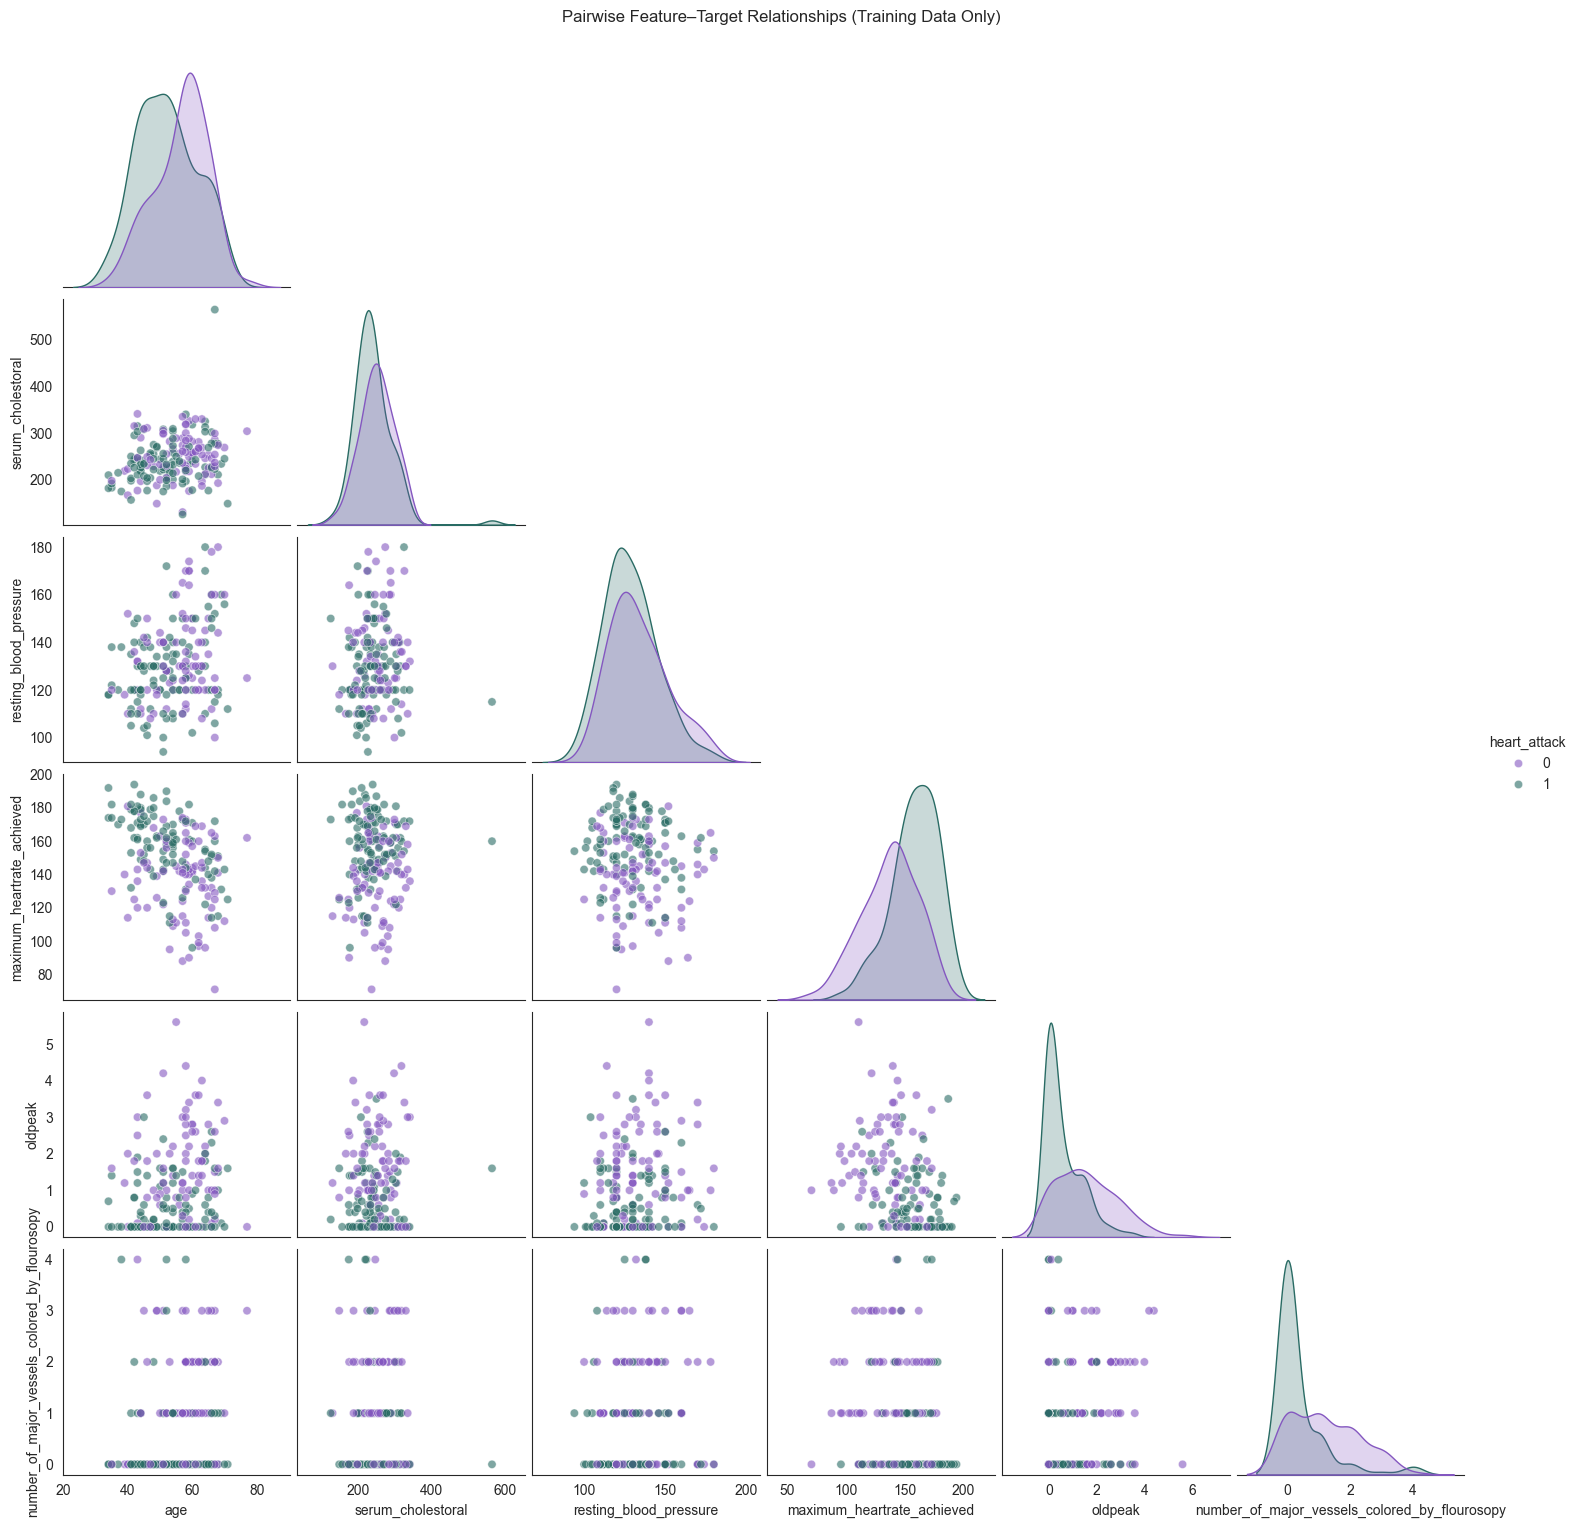

In [135]:
# ----------------------------------
# Pair Plot: Feature vs Target
# ----------------------------------

pair_cols = [
    "age",
    "serum_cholestoral",
    "resting_blood_pressure",
    "maximum_heartrate_achieved",
    "oldpeak",
    "number_of_major_vessels_colored_by_flourosopy",
    "heart_attack"
]

pair_df = pd.concat(
    [X_train[pair_cols[:-1]], y_train.rename("heart_attack")],
    axis=1
)

sns.pairplot(
    pair_df,
    hue="heart_attack",
    corner=True,
    diag_kind="kde",
    palette=["#8457C0", "#296B64FF"],
    plot_kws={"alpha": 0.6}
)
plt.suptitle(
    "Pairwise Feature–Target Relationships (Training Data Only)",
    y=1.02
)
plt.show()


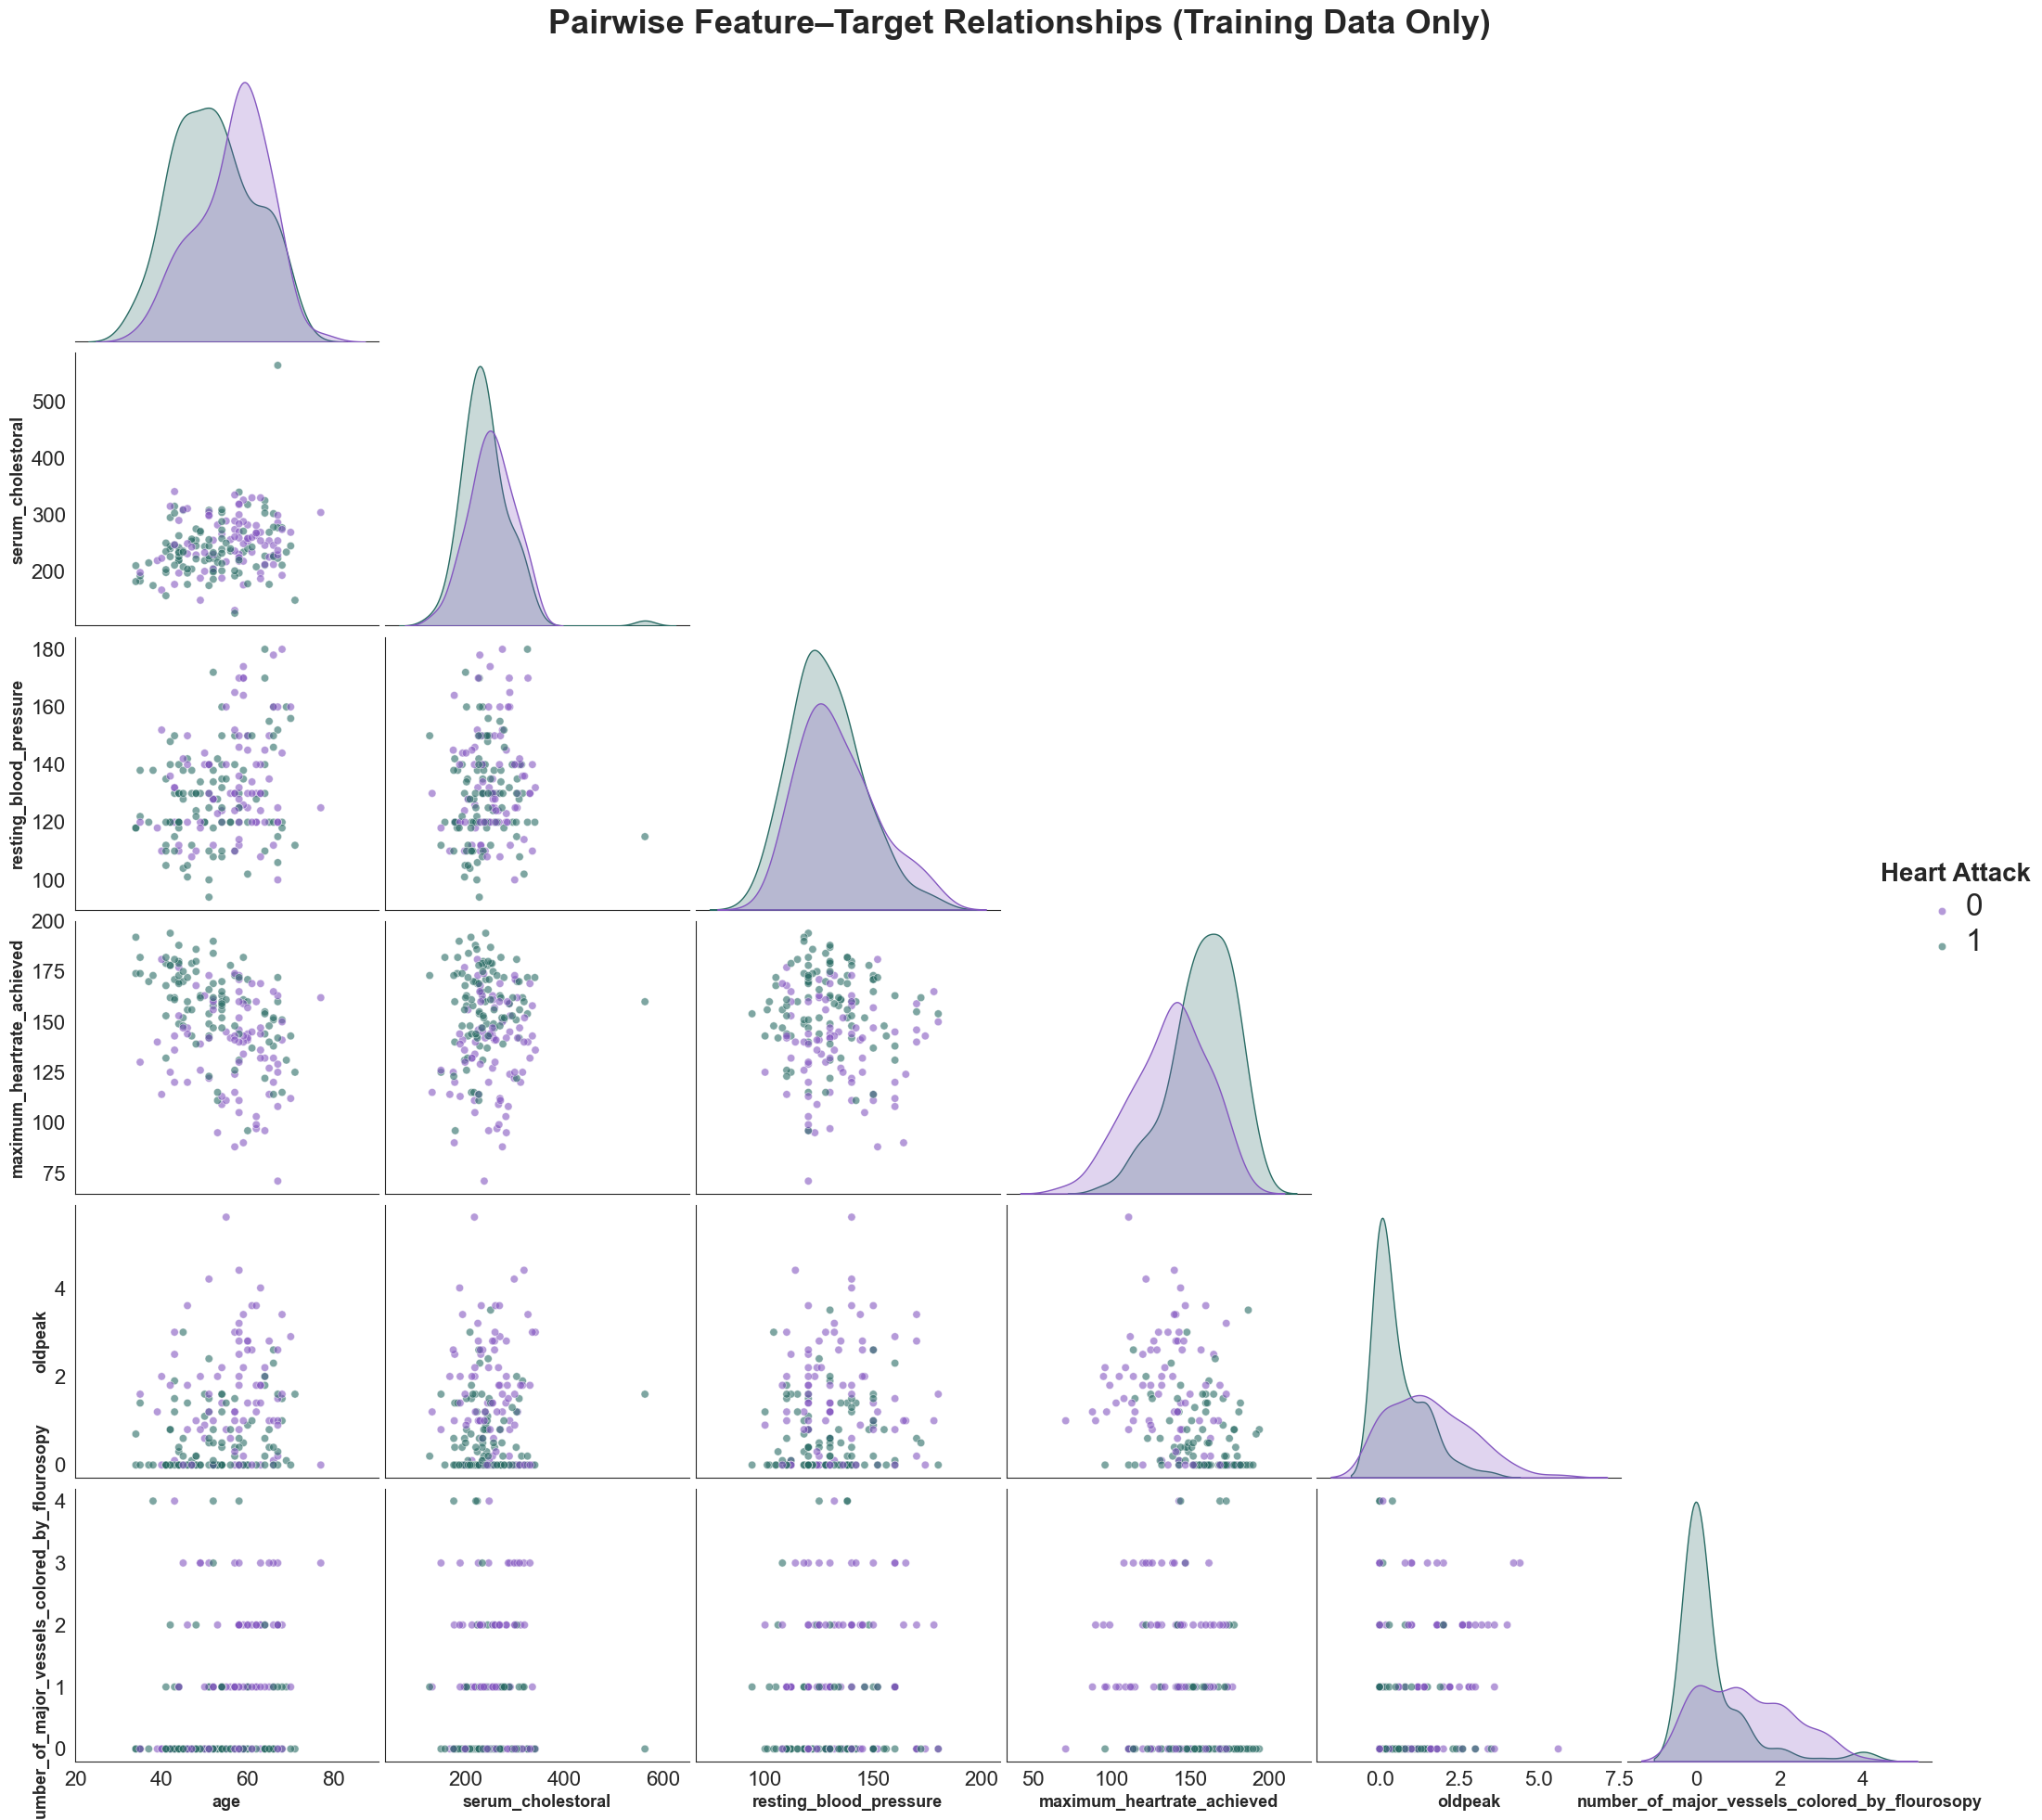

In [161]:
# ----------------------------------
# Pair Plot: Feature vs Target (Readable Version)
# ----------------------------------

pair_cols = [
    "age",
    "serum_cholestoral",
    "resting_blood_pressure",
    "maximum_heartrate_achieved",
    "oldpeak",
    "number_of_major_vessels_colored_by_flourosopy",
    "heart_attack"
]

pair_df = pd.concat(
    [X_train[pair_cols[:-1]], y_train.rename("heart_attack")],
    axis=1
)

g = sns.pairplot(
    pair_df,
    hue="heart_attack",
    corner=True,
    diag_kind="kde",
    palette=["#8457C0", "#296B64FF"],
    plot_kws={"alpha": 0.6},
    height=3.2,        # size of each subplot
    aspect=1.1
)
for ax in g.axes.flatten():
    if ax is not None:
        ax.xaxis.label.set_size(13)
        ax.yaxis.label.set_size(13)
        ax.xaxis.label.set_weight("bold")
        ax.yaxis.label.set_weight("bold")

# ---------- Improve legend readability ----------
if g._legend is not None:
    g._legend.set_title("Heart Attack", prop={"size": 20, "weight": "bold"})
    for text in g._legend.texts:
        text.set_fontsize(24)

# ---------- Improve tick labels ----------
for ax in g.axes.flatten():
    if ax is not None:
        ax.tick_params(labelsize=16)

# ---------- Title ----------
g.fig.suptitle(
    "Pairwise Feature–Target Relationships (Training Data Only)",
    fontsize=26,
     fontweight="bold",
    y=1.02
)

plt.show()


Both `maximum_heartrate_achieved` and `oldpeak` individually exhibit strong
associations with the target variable and show clear class separation patterns.
In addition, their joint distribution reveals an even stronger separation
effect, indicating the presence of meaningful **interaction effects** between
these two features.

### 3.5 Feature Engineering and Preprocessing Design

#### 3.5.1 Feature Grouping

Features are grouped based on their semantic meaning and preprocessing
requirements in order to construct modular and leakage-safe preprocessing
pipelines. This grouping enables tailored transformations for different data
types while preserving interpretability and model robustness.

**Continuous / Discrete Numerical Features**
These variables represent true numerical magnitudes with meaningful numeric
distances. They are suitable for scaling and numerical imputation strategies.
This group includes both continuous measurements and discrete count-based
features.

Notably, `number_of_major_vessels_colored_by_flourosopy` is treated as a
numerical feature despite being discrete, as it represents a true count
variable where differences between values reflect actual quantitative changes
(e.g., the number of affected vessels).

**Binary Categorical Features**
Binary variables encoded as 0/1 are treated as categorical indicators rather
than continuous quantities. These features represent the presence or absence
of a condition and therefore do not require scaling but may require imputation.

**Non-Binary Categorical Features**
Multi-class categorical variables are processed separately using encoding
techniques such as one-hot encoding. Although some of these variables (e.g.
`slope_of_the_peak_exercise_st_segment` and
`resting_electrocardiographic_results`) are ordinal in nature, they are handled
as categorical features to avoid imposing artificial linear relationships
between category levels.

This structured grouping provides the foundation for constructing dedicated
preprocessing pipelines that are later combined using a ColumnTransformer.


In [ ]:
# ----------------------------------
# 3.5.1 Feature Grouping
# ----------------------------------

# Continuous / discrete numerical features (regular numeric)
num_features = [
    "age",
    "serum_cholestoral",
    "resting_blood_pressure",
    "maximum_heartrate_achieved",
    "number_of_major_vessels_colored_by_flourosopy"
]

# Skewed numerical feature (special treatment)
oldpeak_feature = [
    "oldpeak"
]

# Binary categorical features (encoded as 0/1 but treated as categorical)
bin_features = [
    "sex",
    "fasting_blood_sugar",
    "exercise_induced_angina"
]

# Non-binary categorical features
cat_features = [
    "chest_pain_type",
    "resting_electrocardiographic_results",
    "slope_of_the_peak_exercise_st_segment",
    "thal"
]

# Sanity check: make sure all columns are assigned
all_features = num_features + oldpeak_feature + bin_features + cat_features

set(X_train.columns) - set(all_features)



set()

#### 3.5.2 Pipeline Design per Feature Group

In [163]:
# ----------------------------------
# 3.5.2 Pipeline Design per Feature Group
# ----------------------------------

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
import numpy as np


# -------- Numerical pipeline (regular numeric features) --------
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


# -------- Oldpeak pipeline (skewed numeric feature) --------
oldpeak_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])


# -------- Binary categorical pipeline --------
bin_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
    # No scaling applied to binary indicators
])


# -------- Non-binary categorical pipeline --------
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


#### 3.5.3 ColumnTransformer Assembly

In [164]:
# ----------------------------------
# 3.5.3 ColumnTransformer Assembly
# ----------------------------------

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("oldpeak", oldpeak_pipeline, oldpeak_feature),
        ("bin", bin_pipeline, bin_features),
        ("cat", cat_pipeline, cat_features)
    ],
    remainder="drop"   # Drop any columns not explicitly listed
)

preprocessor


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('oldpeak', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name`

## 4. Modeling and Evaluation

### 4.1 Model 1 — Logistic Regression (Baseline)

This section evaluates logistic regression as the baseline classification model
for predicting heart attack risk.

Three variants are considered:

* **Model 1a — Logistic Regression (no regularization)**
* **Model 1b — Logistic Regression with L2 regularization (cross-validated)**
* **Model 1c — Logistic Regression with L1 regularization (cross-validated)**

All models use the same preprocessing pipeline defined in Section 3.5. Due to
the approximately balanced class distribution, no explicit class weighting is
applied.

Model performance is evaluated on the held-out test set using a fixed decision
threshold of `t = 0.50`. Model comparison primarily relies on **ROC-AUC**, while
additional metrics (accuracy, precision, recall, and F1-score) are reported for
completeness. Threshold optimization is addressed in a later section.


In [177]:
# ==========================================
# Model 1 — Logistic Regression (Baseline)
#   1a) Logistic (no regularization)
#   1b) Logistic + L2 (CV)
#   1c) Logistic + L1 (CV)
# ==========================================


rows = []


# ==================================
# 1a) Logistic — NO regularization
# ==================================

pipe_logit_plain = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C=1e6,
        solver="lbfgs",
        max_iter=3000,
        random_state=RANDOM_STATE
    ))
])

pipe_logit_plain.fit(X_train, y_train)

y_pred_1a  = pipe_logit_plain.predict(X_test)
y_proba_1a = pipe_logit_plain.predict_proba(X_test)[:, 1]

rows.append(
    metric_report(
        y_test,
        y_pred_1a,
        y_proba_1a,
        label="Model 1a — Logistic (No Reg)"
    )
)


# ==================================
# 1b) Logistic — L2 Regularization (CV)
# ==================================

pipe_logit_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegressionCV(
        Cs=10,                    # Number of regularization strengths to test
        cv=5,                     # 5-fold cross-validation
        solver="lbfgs",           # Optimizer suited for L2 regularization
        tol=1e-3,                 # Convergence tolerance (faster stopping)
        scoring="roc_auc",        # Metric used for model selection
        l1_ratios=(0,),           # L2 regularization (API-compatible setting)
        max_iter=5000,            # Maximum optimization iterations
        n_jobs=-1,                # Use all available CPU cores
        random_state=RANDOM_STATE,# Reproducibility
        use_legacy_attributes=True # Suppress future attribute warnings
    ))
])


pipe_logit_l2.fit(X_train, y_train)

y_pred_1b  = pipe_logit_l2.predict(X_test)
y_proba_1b = pipe_logit_l2.predict_proba(X_test)[:, 1]

best_c_l2 = pipe_logit_l2.named_steps["classifier"].C_[0]

print("\nBest C (L2):", best_c_l2.round(4))

rows.append(
    metric_report(
        y_test,
        y_pred_1b,
        y_proba_1b,
        label="Model 1b — Logistic L2 (CV)"
    )
)


# ==================================
# 1c) Logistic — L1 Regularization (CV)
# ==================================

pipe_logit_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegressionCV(
        Cs=10,
        cv=5,
        solver="saga",
        scoring="roc_auc",
        l1_ratios=(1,),
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        use_legacy_attributes=True
    ))
])
pipe_logit_l1.fit(X_train, y_train)

y_pred_1c  = pipe_logit_l1.predict(X_test)
y_proba_1c = pipe_logit_l1.predict_proba(X_test)[:, 1]

best_c_l1 = pipe_logit_l1.named_steps["classifier"].C_[0]

print("Best C (L1):", best_c_l1.round(4))

rows.append(
    metric_report(
        y_test,
        y_pred_1c,
        y_proba_1c,
        label="Model 1c — Logistic L1 (CV)"
    )
)


# ==========================================
# Comparison Table
# ==========================================

df_model1_compare = pd.DataFrame(rows)
display(df_model1_compare.round(4))



Best C (L2): 0.0008
Best C (L1): 0.3594


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1a — Logistic (No Reg),0.8367,0.8276,0.7727,0.8889,0.8571,0.9175,0.9328
1,Model 1b — Logistic L2 (CV),0.5510,0.5510,0.0000,1.0000,0.7105,0.9091,0.9337
2,Model 1c — Logistic L1 (CV),0.8367,0.8276,0.7727,0.8889,0.8571,0.9040,0.9231


### 4.1.1 Decision Threshold Optimization (Model 1a)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.653,0.614,0.227,1.0,0.761,0.918,0.933
1,0.02,0.673,0.628,0.273,1.0,0.771,0.918,0.933
2,0.03,0.714,0.659,0.364,1.0,0.794,0.918,0.933
3,0.04,0.714,0.659,0.364,1.0,0.794,0.918,0.933
4,0.05,0.714,0.659,0.364,1.0,0.794,0.918,0.933


F1-optimal threshold: 0.52 (F1-max)
Precision≥0.70 threshold: 0.11 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.75 (recall≥0.7, max precision)


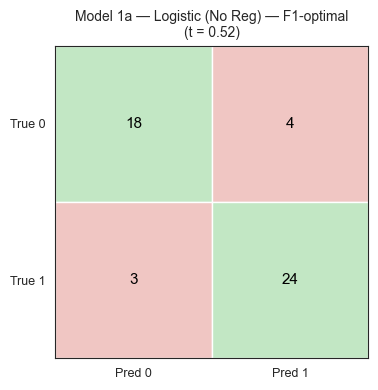

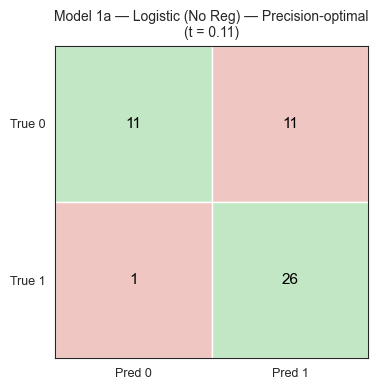

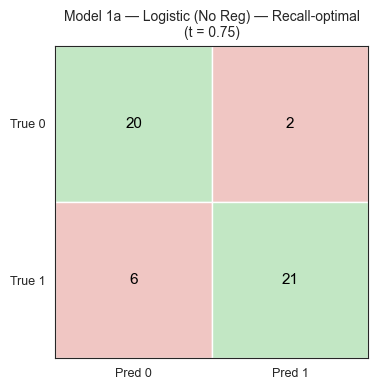


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1a — Logistic (No Reg) — F1-optimal (t=0...,0.8571,0.8571,0.8182,0.8889,0.8727,0.9175,0.9328



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1a — Logistic (No Reg) — Precision-optim...,0.7551,0.7027,0.5,0.963,0.8125,0.9175,0.9328



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1a — Logistic (No Reg) — Recall-optimal ...,0.8367,0.913,0.9091,0.7778,0.84,0.9175,0.9328


In [179]:
# ============================================
# Threshold Optimization — Model 1a
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_1a
model_label  = "Model 1a — Logistic (No Reg)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)


# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


### 4.2 Model 2 — SGD-based Logistic Regression

In [180]:
# ==========================================
# Model 2 — SGD Logistic Regression
#   2a) SGD Logistic (no regularization)
#   2b) SGD Logistic + L2
#   2c) SGD Logistic + L1
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import pandas as pd

rows_sgd = []


# ==================================
# 2a) SGD Logistic — NO regularization
# ==================================

pipe_sgd_plain = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SGDClassifier(
        loss="log_loss",          # logistic regression
        penalty=None,             # no regularization
        max_iter=3000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ))
])

pipe_sgd_plain.fit(X_train, y_train)

y_pred_2a  = pipe_sgd_plain.predict(X_test)
y_proba_2a = pipe_sgd_plain.predict_proba(X_test)[:, 1]

rows_sgd.append(
    metric_report(
        y_test,
        y_pred_2a,
        y_proba_2a,
        label="Model 2a — SGD Logistic (No Reg)"
    )
)


# ==================================
# 2b) SGD Logistic — L2 Regularization
# ==================================

pipe_sgd_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SGDClassifier(
        loss="log_loss",
        penalty="l2",             # L2 regularization
        alpha=0.0001,             # regularization strength
        max_iter=3000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ))
])

pipe_sgd_l2.fit(X_train, y_train)

y_pred_2b  = pipe_sgd_l2.predict(X_test)
y_proba_2b = pipe_sgd_l2.predict_proba(X_test)[:, 1]

rows_sgd.append(
    metric_report(
        y_test,
        y_pred_2b,
        y_proba_2b,
        label="Model 2b — SGD Logistic L2"
    )
)


# ==================================
# 2c) SGD Logistic — L1 Regularization
# ==================================

pipe_sgd_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SGDClassifier(
        loss="log_loss",
        penalty="l1",             # L1 regularization
        alpha=0.0001,
        max_iter=3000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ))
])

pipe_sgd_l1.fit(X_train, y_train)

y_pred_2c  = pipe_sgd_l1.predict(X_test)
y_proba_2c = pipe_sgd_l1.predict_proba(X_test)[:, 1]

rows_sgd.append(
    metric_report(
        y_test,
        y_pred_2c,
        y_proba_2c,
        label="Model 2c — SGD Logistic L1"
    )
)


# ==========================================
# Comparison Table — SGD Models
# ==========================================

df_model2_compare = pd.DataFrame(rows_sgd)
display(df_model2_compare.round(4))


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2a — SGD Logistic (No Reg),0.8571,0.8333,0.7727,0.9259,0.8772,0.9040,0.9172
1,Model 2b — SGD Logistic L2,0.8571,0.8333,0.7727,0.9259,0.8772,0.9007,0.9124
2,Model 2c — SGD Logistic L1,0.7959,0.7931,0.7273,0.8519,0.8214,0.8721,0.8962


### 4.2.1 Decision Threshold Optimization (Model 1a)

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.816,0.765,0.636,0.963,0.852,0.904,0.917
1,0.02,0.816,0.765,0.636,0.963,0.852,0.904,0.917
2,0.03,0.816,0.781,0.682,0.926,0.847,0.904,0.917
3,0.04,0.837,0.806,0.727,0.926,0.862,0.904,0.917
4,0.05,0.837,0.806,0.727,0.926,0.862,0.904,0.917


F1-optimal threshold: 0.92 (F1-max)
Precision≥0.70 threshold: 0.01 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.92 (recall≥0.7, max precision)


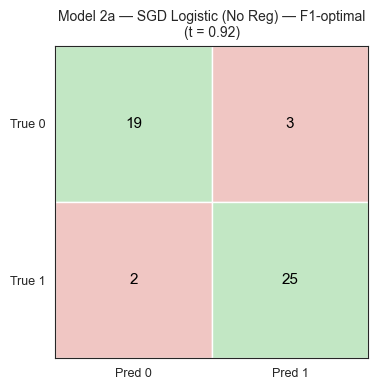

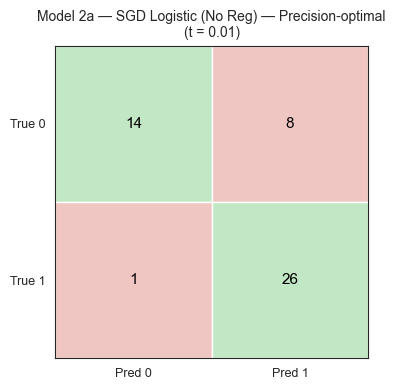

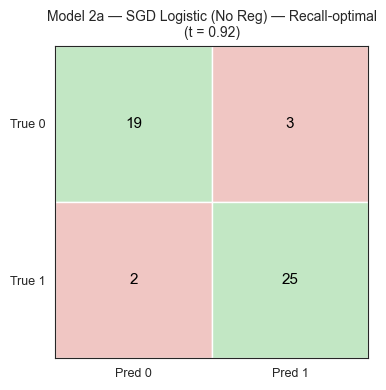


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2a — SGD Logistic (No Reg) — F1-optimal ...,0.898,0.8929,0.8636,0.9259,0.9091,0.904,0.9172



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2a — SGD Logistic (No Reg) — Precision-o...,0.8163,0.7647,0.6364,0.963,0.8525,0.904,0.9172



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2a — SGD Logistic (No Reg) — Recall-opti...,0.898,0.8929,0.8636,0.9259,0.9091,0.904,0.9172


In [181]:
# ============================================
# Threshold Optimization — Model 2a
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_2a
model_label  = "Model 2a — SGD Logistic (No Reg)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)


# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


## 4.3 Model 3 — Support Vector Machines with CV

This section evaluates Support Vector Machine (SVM) classifiers as
margin-based alternatives to logistic regression.

Two variants are considered:
- **Model 3a — Linear SVC**
- **Model 3b — SVC with RBF kernel**

All models use the same preprocessing pipeline and handle class imbalance
via class weighting. Evaluation is performed on the test set at a fixed
threshold of `t = 0.50` prior to threshold optimization.
Probability estimates are enabled for SVM models to allow PR-AUC evaluation and decision threshold optimization.

In [183]:
# ==========================================
# Model 3 — Support Vector Machines (CV)
#   3a) Linear SVC (CV on C)
#   3b) RBF SVC (CV on C and gamma)
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

rows_svc = []


# ==================================
# 3a) Linear SVC — CV on C
# ==================================

pipe_svc_linear = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="linear",
        probability=True,
        random_state=RANDOM_STATE
    ))
])

param_grid_linear = {
    "classifier__C": [0.01, 0.1, 1, 10, 100]
}

grid_svc_linear = GridSearchCV(
    pipe_svc_linear,
    param_grid=param_grid_linear,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_svc_linear.fit(X_train, y_train)

best_linear_model = grid_svc_linear.best_estimator_
best_c_linear = grid_svc_linear.best_params_["classifier__C"]

print("\nBest C (Linear SVC):", best_c_linear)

y_pred_3a  = best_linear_model.predict(X_test)
y_proba_3a = best_linear_model.predict_proba(X_test)[:, 1]

rows_svc.append(
    metric_report(
        y_test,
        y_pred_3a,
        y_proba_3a,
        label="Model 3a — Linear SVC (CV)"
    )
)


# ==================================
# 3b) RBF SVC — CV on C and gamma
# ==================================

pipe_svc_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",
        probability=True,
        random_state=RANDOM_STATE
    ))
])

param_grid_rbf = {
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__gamma": ["scale", 0.1, 0.01, 0.001]
}

grid_svc_rbf = GridSearchCV(
    pipe_svc_rbf,
    param_grid=param_grid_rbf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_svc_rbf.fit(X_train, y_train)

best_rbf_model = grid_svc_rbf.best_estimator_
best_c_rbf     = grid_svc_rbf.best_params_["classifier__C"]
best_gamma_rbf = grid_svc_rbf.best_params_["classifier__gamma"]

print("Best C (RBF SVC):", best_c_rbf)
print("Best gamma (RBF SVC):", best_gamma_rbf)

y_pred_3b  = best_rbf_model.predict(X_test)
y_proba_3b = best_rbf_model.predict_proba(X_test)[:, 1]

rows_svc.append(
    metric_report(
        y_test,
        y_pred_3b,
        y_proba_3b,
        label="Model 3b — RBF SVC (CV)"
    )
)


# ==========================================
# Comparison Table — Tuned SVC Models
# ==========================================

df_model3_compare = pd.DataFrame(rows_svc)
display(df_model3_compare.round(4))



Best C (Linear SVC): 0.01
Best C (RBF SVC): 10
Best gamma (RBF SVC): 0.001


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3a — Linear SVC (CV),0.7959,0.7576,0.6364,0.9259,0.8333,0.9108,0.9338
1,Model 3b — RBF SVC (CV),0.8163,0.7812,0.6818,0.9259,0.8475,0.9040,0.9270


### 4.3.1 Decision Threshold Optimization (Model 3a)
Predicted probabilities are fixed and evaluated across multiple thresholds
to support different business objectives.

,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.551,0.551,0.000,1.0,0.711,0.911,0.934
1,0.02,0.612,0.587,0.136,1.0,0.740,0.911,0.934
2,0.03,0.612,0.587,0.136,1.0,0.740,0.911,0.934
3,0.04,0.633,0.600,0.182,1.0,0.750,0.911,0.934
4,0.05,0.653,0.614,0.227,1.0,0.761,0.911,0.934


F1-optimal threshold: 0.48 (F1-max)
Precision≥0.70 threshold: 0.16 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.66 (recall≥0.7, max precision)


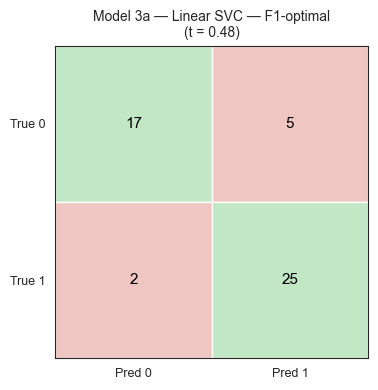

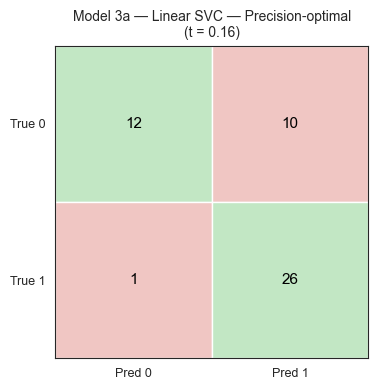

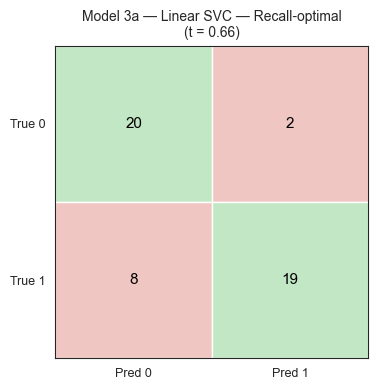


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3a — Linear SVC — F1-optimal (t=0.48),0.8571,0.8333,0.7727,0.9259,0.8772,0.9108,0.9338



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3a — Linear SVC — Precision-optimal (t=0...,0.7755,0.7222,0.5455,0.963,0.8254,0.9108,0.9338



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3a — Linear SVC — Recall-optimal (t=0.66),0.7959,0.9048,0.9091,0.7037,0.7917,0.9108,0.9338


In [184]:
# ============================================
# Threshold Optimization — Model 3a
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_3a
model_label  = "Model 3a — Linear SVC"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal"
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal"
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal"
)


# ---------------------
# Summary tables
# ---------------------
print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))
